Notebook notes: this notebook is basically computing test set results for the training done for the segmentation model

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import sys
sys.path.insert(0, '../utils')
from ground_truth_dataset import groundTruthDataset
from data_functions import splitDataset, returnLoaders
from metrics import returnPreReF
sys.path.insert(0, '../models')
from unet_model import UNet
sys.path.insert(0, '../train')
from training import train_one_epoch, valid_one_epoch 

# Loss Curves

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Iteration Training Loss', 'Iteration Validation Loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


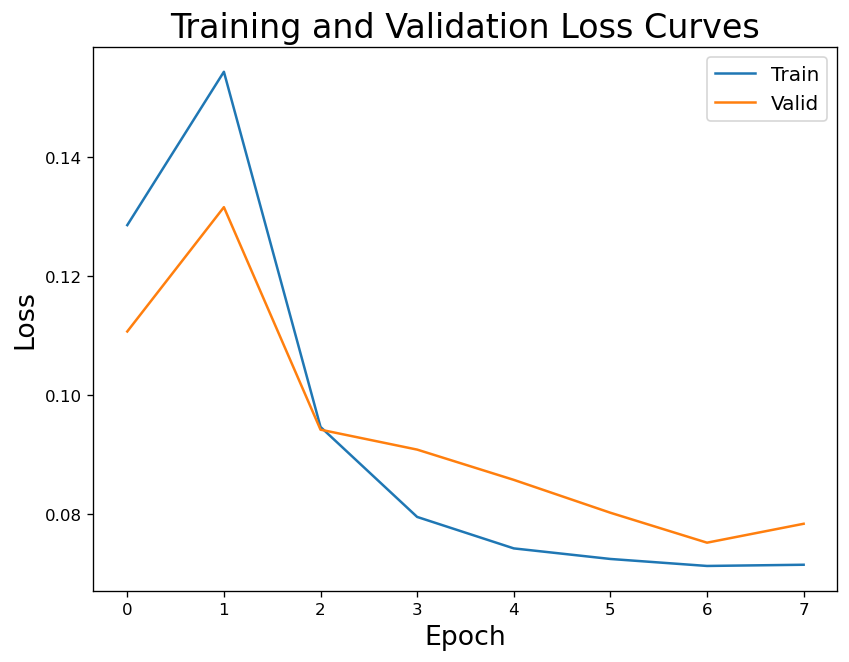

In [2]:
logdir = '../logs/groundtruth/08_13_groundtruth_lr_0.0003_epochs_10_batch_size_4/'
event_acc = EventAccumulator(logdir)
event_acc.Reload()
print(event_acc.Tags())
_, _, tr_iter_loss = zip(*event_acc.Scalars('Iteration Training Loss'))
_, _, val_iter_loss = zip(*event_acc.Scalars('Iteration Validation Loss'))
tr_epoch_loss = [np.mean(tr_iter_loss[(193*i):(193*2*i-1)]) for i in range(8)]
val_epoch_loss = [np.mean(val_iter_loss[(42*i):(42*2*i-1)]) for i in range(8)]
fig = plt.figure(figsize = (8,6), dpi = 120)
plt.plot(list(range(len(tr_epoch_loss))), tr_epoch_loss, label = "Train")
plt.plot(list(range(len(val_epoch_loss))), val_epoch_loss, label = "Valid")
plt.ylabel("Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.title("Training and Validation Loss Curves", fontsize=20)
plt.legend(fontsize = 12)

In [3]:
[np.mean(tr_iter_loss[(193*i):(193*2*i-1)]) for i in range(8)]
#[np.mean(val_iter_loss[(42*i):(42*2*i-1)]) for i in range(8)]
    

[0.1285309319372928,
 0.15429505030624568,
 0.09462797692069759,
 0.07950895690201269,
 0.07422366673573755,
 0.0724464050447488,
 0.07127226672950804,
 0.07147568250026727]

# Training Examples

In [4]:
NUM_CLASSES = 2 # For ground truth data, there's 2 classes of Background, CAFO
batch_size = 8
model = UNet(3, 2)
model.load_state_dict(torch.load('../../../saved_models/finished/model8_10_ia_data.pth'))
dataset = groundTruthDataset("../../../../../datadrive/data/raw/ground_truth/", 
                             transform=True, 
                             make_small=True, 
                             ignore_lagoon=True)
#dataset = groundTruthDataset("../../../segmentation_ground_truth", make_small=True)
datasets = splitDataset(dataset)
trainloader, validloader, testloader = returnLoaders(datasets, batch_size, True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
test_num_batches = len(testloader)
test_num_examples = len(testloader.dataset)

#Set model to either cpu or gpu
model.to(device)            

#Define loss function
#Weight due to class imbalance
pos_weight = torch.tensor([1, 30]) #23 is good when doing 3 class
pos_weight = torch.reshape(pos_weight,(1,2,1,1)).to(device)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,
                                     weight_decay = 1e-7)

In [7]:
today = date.today()
date_prefix = today.strftime("%m_%d")
log_dir_suffix = f"{date_prefix}_groundtruth_lr_{3e-4}_epochs_{10}_batch_size_{4}"
log_dir = "../logs/groundtruth/" + log_dir_suffix
writer = SummaryWriter(log_dir=log_dir)

In [8]:
torch.manual_seed(0)
np.random.seed(0)
model.zero_grad()
class_list = [0, 1]

In [9]:
epoch = 0
test_loss = []
test_correct = 0

conf_matrix = np.zeros((2, 2))

with tqdm(total = test_num_batches) as epoch_pbar:
    model.eval()                           
    test_loss, test_correct, \
        conf_matrix, valid_IoU = valid_one_epoch(epoch, test_num_batches, model, 
                                                 device, testloader, epoch_pbar, 
                                                 optimizer, writer, criterion,
                                                 conf_matrix, class_list)

Epoch 0 - loss 0.0795 - acc 0.9902 - Mean IoU 0.2235 - Precision 0.2710 - Recall 0.5605: 100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


In [10]:
precision, recall, f_score = returnPreReF(conf_matrix, 1)

In [11]:
print(precision)
print(recall)
print(f_score)

0.2710084925690021
0.5604641079259491
0.3653530686101406


In [12]:
# Testing it out on validation
val_example = next(iter(testloader))
inputs = val_example[0].to(device)
labels = val_example[1].to(device)
with torch.no_grad():
    outputs = model(inputs)
_, predictions = torch.max(outputs, 1)
predictions_one_hot = torch.nn.functional.one_hot(predictions).permute(0, 3, 1, 2)
y_pred = predictions.flatten().cpu().numpy()
_, blah = torch.max(labels, 1)

y_true = blah.flatten().cpu().numpy()

In [13]:
good_idx = [0, 2, 3, 4, 7]
new_inputs = inputs[good_idx, :]
new_labels = labels[good_idx, :]
new_preds = predictions_one_hot[good_idx, :]

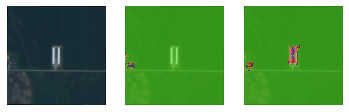

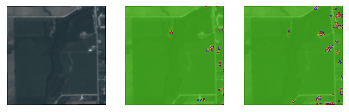

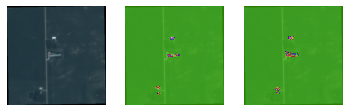

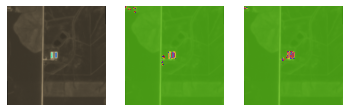

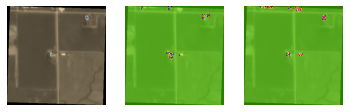

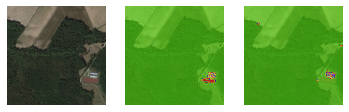

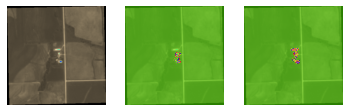

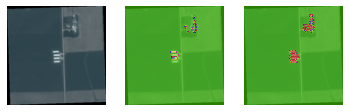

In [14]:
kwarg_dict = { 'BACKGROUND':{'cmap':'prism', 'alpha': 0.5},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'CAFO Shed': {'cmap':'hot', 'alpha': 0.0}}

for i in range(8):
    f = plt.figure()
    changedInput = (inputs[i].permute(1, 2, 0).cpu().numpy() * 255).astype('uint8') 
    
    a= f.add_subplot(1, 3, 1)    
    plt.imshow(changedInput)
    plt.axis('off')
    
    a= f.add_subplot(1, 3, 2)        
    plt.imshow(changedInput)
    if labels != None:
        plt.imshow(labels[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
        plt.imshow(labels[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed']) 
    plt.axis('off')

    a = f.add_subplot(1, 3, 3)
    plt.imshow(changedInput)
    plt.imshow(predictions_one_hot[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(predictions_one_hot[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])    
    plt.axis('off')

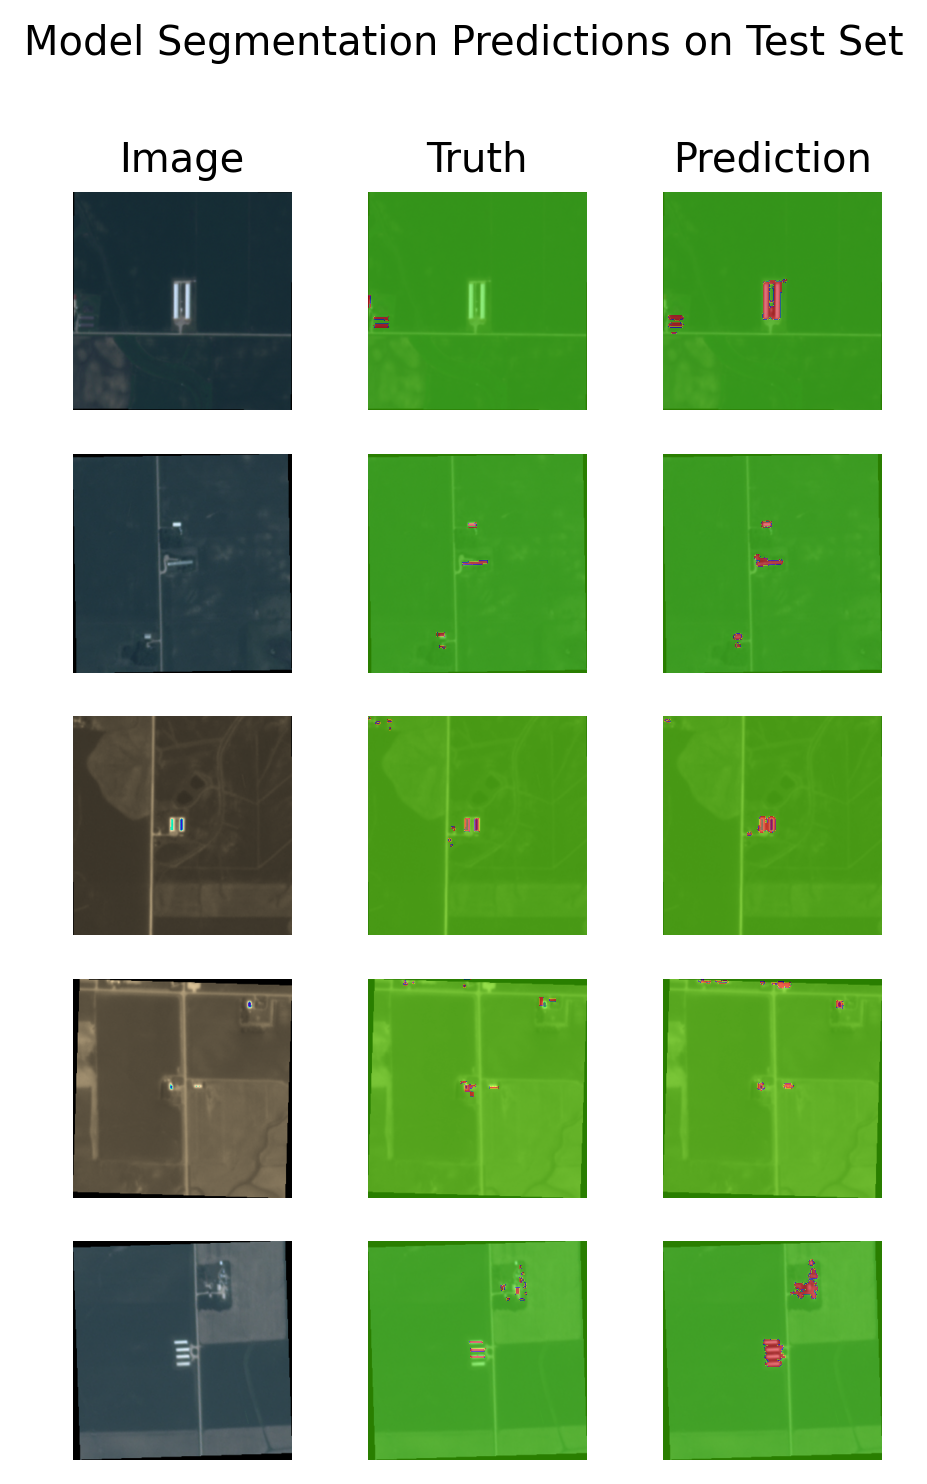

In [15]:
kwarg_dict = { 'BACKGROUND':{'cmap':'prism', 'alpha': 0.5},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'CAFO Shed': {'cmap':'hot', 'alpha': 0.0}}

f = plt.figure(figsize=(4.5,7), dpi=240)
f.suptitle("Model Segmentation Predictions on Test Set")
for i in range(len(good_idx)):
    changedInput = (new_inputs[i].permute(1, 2, 0).cpu().numpy() * 255).astype('uint8') 
    
    a1= f.add_subplot(len(good_idx), 3, 3*i + 1)
    plt.imshow(changedInput)
    
    plt.axis('off')
    
    
    a2= f.add_subplot(len(good_idx), 3, 3*i + 2)        
    plt.imshow(changedInput)
    plt.imshow(new_labels[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(new_labels[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed']) 
    plt.axis('off')

    a3 = f.add_subplot(len(good_idx), 3, 3*i + 3)
    plt.imshow(changedInput)
    plt.imshow(new_preds[i][0].cpu().numpy(), **kwarg_dict['BACKGROUND'])
    plt.imshow(new_preds[i][1].cpu().numpy(), **kwarg_dict['CAFO Shed'])    
    plt.axis('off')
    
    if i == 0:
        a1.set_title("Image")
        a2.set_title("Truth")
        a3.set_title("Prediction")